In [1]:
### MASTER_Script_python3
'''
This is MASTER_Script_python3 for evaluation of FESOM2-REcoM output. 
Adapted from py_recom/GlobalAssesment/MASTER_Script.ipynb

Please install:
-pyfesom2
-skillmetrics
-cartopy

Caution: As basemap gets deprecated, pyfesom2 (thus, this sript as well) use cartopy instead. 
Using Robinson projection needs more time than the standard Plate Carree projection.

Tracers are calculated at midlayer depths, c.f. https://fesom2.readthedocs.io/en/latest/geometry.html
'''

'\nThis is MASTER_Script_python3 for evaluation of FESOM2-REcoM output. \nAdapted from py_recom/GlobalAssesment/MASTER_Script.ipynb\n\nPlease install:\n-pyfesom2\n-skillmetrics\n-cartopy\n\nCaution: As basemap gets deprecated, pyfesom2 (thus, this sript as well) use cartopy instead. \nUsing Robinson projection needs more time than the standard Plate Carree projection.\n\nTracers are calculated at midlayer depths, c.f. https://fesom2.readthedocs.io/en/latest/geometry.html\n'

In [2]:
# Run mo15
# increased deg$_{Chl}$ = 0.5, deg$_{Chl,d}$ = 0.5
# with pacific hydrothermal vent masked

In [3]:
%matplotlib inline
%autosave 5

Autosaving every 5 seconds


In [4]:
# necessary modules -------------------------------------------------------------------------------------
import pyfesom2 as pf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import time
from datetime import date

#import sys
#sys.path.append('home/ollie/mozeisin/SkillMetrics')

import cartopy.crs as ccrs
#import pangaeapy.pandataset as pd

# own py_recom modules ----------------------------------------------------------------------
#!jupyter nbconvert --to=python *.ipynb
!jupyter nbconvert --to=python load_interp_WOA_python3.ipynb
!jupyter nbconvert --to=python plot_Taylor_normalized.ipynb

!jupyter nbconvert --to=python plot_Chlorophyll_FESOM_python3.ipynb
from plot_Chlorophyll_FESOM_python3 import plot_Chl


[NbConvertApp] Converting notebook load_interp_WOA_python3.ipynb to python
[NbConvertApp] Writing 17424 bytes to load_interp_WOA_python3.py
[NbConvertApp] Converting notebook plot_Taylor_normalized.ipynb to python
[NbConvertApp] Writing 4239 bytes to plot_Taylor_normalized.py
[NbConvertApp] Converting notebook plot_Chlorophyll_FESOM_python3.ipynb to python
[NbConvertApp] Writing 3898 bytes to plot_Chlorophyll_FESOM_python3.py


In [5]:
# After changing these parameters here, save the notebook and clear the output. 
# Then run this cell and the cells with the desired parameters.

# run specification -------------------------------------------------------------------------------------   
if True:
    runid      =  'fesom'
    layerwise    = False
    resultpath = '/work/ollie/mozeisin/results/f2r1.2/mo7'
    meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

    # period of analysis 
    first_year = 1950
    last_year  = 1970
    
   
if False:    
    runid = 'fesom'
    layerwise = False
    resultpath = '/work/ollie/ogurses/output_f2r2/THIRD_RUN'
    meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'
    
    # period of analysis 
    first_year = 2000
    last_year  = 2007
    
years = [first_year, last_year]

# specification of analysis ------------------------------------------------------------------------------------
depth = 0
layerwise = False
mapproj = 'rob'
#Map projection. Options are Mercator (merc), Plate Carree (pc),
#North Polar Stereo (np), South Polar Stereo (sp),  Robinson (rob)
#Robinson projection is quite time consuming.

# export of analysis ------------------------------------------------------------------------------------
today = date.today().strftime("_%Y_%m_%d")

savepath = '/home/ollie/mozeisin/evaluation/mo_files/test/'
savefig = False
htmlname     =  'test_' + runid + today +'.html'
htmlpath = '/home/ollie/mozeisin/evaluation/mo_files/html/'

# initialization file specifications -----------------------------------------------------------

obspath      = '/home/ollie/mseifert/py_fesom/CreateRunFiles/Initialization/Output/'

ncfileAlk                = '/work/ollie/projects/MarESys/evaluation/GLODAPv2.2016b.TAlk.nc'
ncfileDIC                = '/work/ollie/projects/MarESys/evaluation/GLODAPv2.2016b.TCO2.nc'
ncfileDSi                = '/work/ollie/projects/MarESys/evaluation/woa13_all_i00_01.nc'
ncfileDIN                = '/work/ollie/projects/MarESys/evaluation/woa13_all_n00_01.nc'
ncfileDO2                = '/work/ollie/projects/MarESys/evaluation/woa18_all_o00_01.nc'
ncfileDFe                = '/work/ollie/projects/MarESys/evaluation/fe_pisces_opa_eq_init_3D.nc' 
ncfileNPPTotalGlobal     = '/work/ollie/projects/MarESys/evaluation/'+'fesom.initial.mesh.diag.nc'
ncfileCO2fluxTotalGlobal = '/work/ollie/projects/MarESys/evaluation/'+'fesom.initial.mesh.diag.nc'
ncfileTemp               = '/work/ollie/projects/MarESys/evaluation/woa18_decav_t00_01.nc'
ncfileSal                = '/work/ollie/projects/MarESys/evaluation/woa18_decav_s00_01.nc'
ncfilepCO2               = '/work/ollie/projects/MarESys/evaluation/SOCATv6_tracks_gridded_monthly.nc'
ncfileMLD                = '/work/ollie/projects/MarESys/evaluation/mld_DR003.nc'
matfileChlsurf           = '/work/ollie/projects/MarESys/evaluation/climatology_annual_chl_1deg_OCCCI_2012_2015.mat'
txtfileCO2flux           = '/work/ollie/projects/MarESys/evaluation/CO2_flux2015_Takahashietal2009_original.txt'

ncfileMaredat = "/home/ollie/mozeisin/obs/MarEDat/MarEDat20120716Diatoms.nc"

In [6]:
# just to check
print('Reading out of {0}\nStoring graphs to {1}\nStoring html to {2} as {3}'.format(
    resultpath, savepath, htmlpath, htmlname))

Reading out of /work/ollie/mozeisin/results/f2r1.2/mo7
Storing graphs to /home/ollie/mozeisin/evaluation/mo_files/test/
Storing html to /home/ollie/mozeisin/evaluation/mo_files/html/ as test_fesom_2020_12_07.html


In [7]:
# mesh initialization -----------------------------------------------------------
mesh = pf.load_mesh(meshpath)

if False: # check mesh setup nodal and area
    print(mesh)
    print('with depth levels:')
    print(mesh.zlev)
    
    print('\n\nFESOM mesh.diag:')
    meshdiag=resultpath+'/'+runid+'.mesh.diag.nc'
    #!ncdump -h $meshdiag

    diag = pf.get_meshdiag(mesh,meshdiag=meshdiag, runid=runid)
    print(diag)
    print('depth of layers:')
    mesh_depths = diag['Z'].values
    print(mesh_depths)
    
    nod_area = diag.rename_dims({"nl": "nz1", "nod_n": "nod2"}).nod_area
    nod_area.load()
    #print(np.shape(nod_area[:,:]), type(nod_area))
    
if False:    
    # whole globe
    pf.plot(mesh,np.array(nod_area[0,:]),units='Surface nodal area')
    
    # plot nodal area and mesh structure together
    pf.tplot(mesh, np.array(nod_area[0,:]), ptype='tri', box=[-30, 30, 60, 82], mapproj='np',lw=0.5,units='nodal area')
    pf.tplot(mesh, np.array(nod_area[0,:]), ptype='tri', box=[-30, 30, -30, 30], mapproj='merc',lw=0.5,units='nodal area')

# Physical fields

In [ ]:
!jupyter nbconvert --to=python Temp_WOA_Comparison_python3.ipynb

from Temp_WOA_Comparison_python3 import TEMPcomp
test = TEMPcomp(runid,resultpath,savepath,meshpath,ncfileTemp,first_year,last_year,mapproj=mapproj,savefig=savefig)


In [ ]:
!jupyter nbconvert --to=python Sal_WOA_Comparison_python3.ipynb
from Sal_WOA_Comparison_python3 import SALcomp

#test = SALcomp(runid,resultpath,savepath,meshpath,ncfileSal,first_year,last_year,mapproj=mapproj,savefig=savefig)

# problem: sometimes FESOM salt output (e.g Ozgur's testrun 3) includes all gridpoints in deeper depth 
# and not only ocean points!
# figures using Robinson projections plot false results
# solution: use only Plate Carree
test = SALcomp(runid,resultpath,savepath,meshpath,ncfileSal,first_year,last_year,
               mapproj='pc',
               layerwise=False,savefig=savefig)

In [ ]:
!jupyter nbconvert --to=python MLDspatial_python3.ipynb
from MLDspatial_python3 import MLDspatial_global

test = MLDspatial_global(runid,resultpath,savepath,meshpath,first_year,last_year,mapproj=mapproj,savefig=savefig)
    
'''
Calculate mixed layer depth after Monterey and Levitus, (1997) who 
compute MLD as the depth at which the density over depth differsby 0.125 sigma units 
from the surface density (Griffies et al., 2009). 
This MLD definition was also supported in FESOM1.4 (-->MLD2) 

Definition of Large et al. (1997), who suggest to compute MLD
as the shallowest depth where the vertical derivative of buoyancy
is equal to a local critical buoyancy gradient (Griffies et al., 2009) (-->MLD1).

C.f. oce_ale_pressure_bv.F90

comp. to FESOM 1.4: 
'mlotst'  : mixed layer depth [m], computed with Levitus method (with 0.125 kg/m3 criterion)
'omldamax': daily maximum ocean mixed layer thickness [m] defined by mixing scheme
'''

In [ ]:
## Oxygen

!jupyter nbconvert --to=python DO2_WOA_Comparison_python3.ipynb
from DO2_WOA_Comparison_python3 import DO2comp

test = DO2comp(runid,resultpath,savepath,meshpath,ncfileDO2,first_year,last_year,
               mapproj=mapproj,layerwise=False,savefig=savefig)

# Nutrients

In [ ]:
!jupyter nbconvert --to=python DIN_WOA_Comparison_python3.ipynb

from DIN_WOA_Comparison_python3 import DINcomp
test = DINcomp(runid,resultpath,savepath,meshpath,ncfileDIN,first_year,last_year,mapproj=mapproj,savefig=savefig)


In [ ]:
!jupyter nbconvert --to=python DSi_WOA_Comparison_python3.ipynb
from DSi_WOA_Comparison_python3 import DSicomp

test = DSicomp(runid,resultpath,savepath,meshpath,ncfileDSi,first_year,last_year,mapproj=mapproj,savefig=savefig)

###############################################
### right unit? micro or milimol ??
###############################################

In [ ]:
## DSi at three different depth

#from DSi_WOA_Comparison_depth import DSi_WOA_global_depth
#Test = DSi_WOA_global_depth(runname,resultpath,savepath,modulepath,meshpath,first_year,last_year,mesh_id,ncfileDSi)

test = DSicomp(runid,resultpath,savepath,meshpath,ncfileDSi,first_year,last_year,
               layerwise=True, depth_array = [0,1000,2000],
               mapproj=mapproj,savefig=savefig)

In [ ]:
!jupyter nbconvert --to=python DFe_PISCES_Comparison_python3.ipynb
from DFe_PISCES_Comparison_python3 import DFecomp

test = DFecomp(runid,resultpath,savepath,meshpath,ncfileDFe,first_year,last_year,mapproj=mapproj,savefig=savefig)

In [ ]:
## Nutrients in Mixed Layer
# --> problem: what is the corresponding FESOM2 output concerning daily max. MLD (omldamax) and mlotst?

#!jupyter nbconvert --to=python Nutrients_MLD.ipynb
#from Nutrients_MLD import nut_mld_prof
#Test = nut_mld_prof(runname,resultpath,savepath,modulepath,meshpath,obspath,ncfileMLD,first_year,last_year)
#Test.plot()

In [ ]:
!jupyter nbconvert --to=python Nutrients_depth_python3.ipynb
from Nutrients_depth_python3 import Nut_depth

test = Nut_depth(runid,resultpath,savepath,meshpath,obspath,first_year,last_year,mapproj=mapproj,
                 latminmax=[-90,90],savefig=savefig)

# Carbonate system

In [ ]:
!jupyter nbconvert --to=python DIC_Glodap_Comparison_python3.ipynb
from DIC_Glodap_Comparison_python3 import DICcomp

test = DICcomp(runid,resultpath,savepath,meshpath,ncfileDIC,first_year,last_year,mapproj=mapproj,savefig=savefig)

In [ ]:
!jupyter nbconvert --to=python Alk_Glodap_Comparison_python3.ipynb
from Alk_Glodap_Comparison_python3 import Alkcomp

test = Alkcomp(runid,resultpath,savepath,meshpath,ncfileAlk,first_year,last_year,mapproj=mapproj,savefig=savefig)

In [ ]:
!jupyter nbconvert --to=python pCO2SOCAT_python3.ipynb
from pCO2SOCAT_python3 import pCO2comp

test = pCO2comp(runid,resultpath,savepath,meshpath,ncfilepCO2,first_year,last_year,
                mapproj=mapproj,
                savefig=savefig)

In [ ]:
# there is a change of sign in the script, so that negative is CO2 uptake and positive is CO2 outgassing
!jupyter nbconvert --to=python CO2fluxSpatialTakahashi_python3.ipynb
from CO2fluxSpatialTakahashi_python3 import CO2f_Takahashi_comp

test = CO2f_Takahashi_comp(runid,resultpath,savepath,meshpath,txtfileCO2flux,first_year,last_year,
                           mapproj=mapproj,savefig=savefig)

# Global time-series

In [ ]:
# positive is CO2 uptake, negative is outgassing
!jupyter nbconvert --to=python CO2flux_TotalGlobal_python3.ipynb
from CO2flux_TotalGlobal_python3 import CO2flux_TotalGlobal

test = CO2flux_TotalGlobal(runid,resultpath,savepath,meshpath,first_year,last_year,savefig=savefig)

In [ ]:
# time-series of NPP and export production
!jupyter nbconvert --to=python NPP_TotalGlobal_python3.ipynb
from NPP_TotalGlobal_python3 import NPP_TotalGlobal

test = NPP_TotalGlobal(runid,resultpath,savepath,meshpath,first_year,last_year,savefig=savefig)

### export production --> detritus sinking out of 100 m depth       


# Southern Ocean time-series

In [ ]:
# Timeseries Total SouthernOcean

!jupyter nbconvert --to=python NPP_TotalSouthernOcean_python3.ipynb
from NPP_TotalSouthernOcean_python3 import NPP_TotalSO

test = NPP_TotalSO(runid,resultpath,savepath,meshpath,first_year,last_year,savefig=savefig)

# Biology - Chlorophyll, and NPP

### OCCCI surface Chl

In [ ]:
!jupyter nbconvert --to=python Chlsurf_OCCCI_Comparison_python3.ipynb
from Chlsurf_OCCCI_Comparison_python3 import Chlsurf_OCCCI_comp

# analyze only last 10 years
test = Chlsurf_OCCCI_comp(runid,resultpath,savepath,meshpath,matfileChlsurf,
                          last_year-10,last_year,
                          #first_year,last_year,
                          mapproj=mapproj,savefig=savefig)

########################################################
# check OCCCI documentation on depth range of data!
# http://www.esa-oceancolour-cci.org/
########################################################

### diatom chlorophyll

In [ ]:
# diatom chlorophyll

NCfesom = resultpath + '/DiaChl.fesom.1948.nc'
!ncdump -h $NCfesom

Model depth: 0.0

***
FESOM data was converted, assuming [mg ChlA/m3]
***


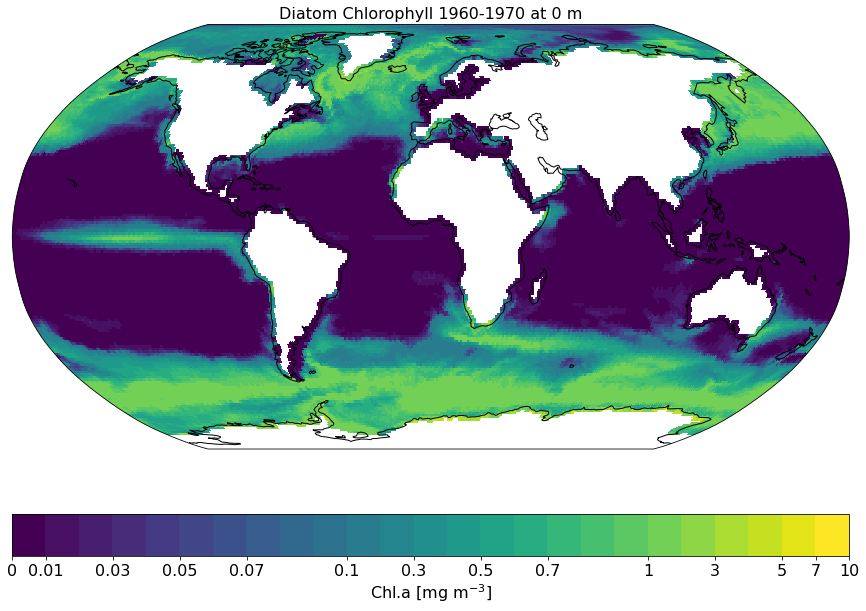

In [8]:
label='Diatom Chlorophyll {0}-{1} at {2} m'.format(last_year-10,last_year,depth)
units = 'Chl.a [mg m$^{-3}$]' # is that really true?

plot_Chl(resultpath,'DiaChl',
         [last_year-10,last_year],
         mesh,runid,depth,mapproj,label,units)

# convert FESOM CHl.a data -------------------------------------------------------------------------------------
#Chl.a : 893.509 g/mol
if False:
    conv = 893.509
    DiaChl = np.log10(DiaChl * conv)
    units = 'log10 Chl.a [mg m$^{-3}$]'
    
    fig = pf.plot(mesh, DiaChl, mapproj = mapproj, units=units, 
              #levels = (-3,3.5,66),
              cmap='viridis',
              titles=label)

### nanophytoplankton chlorophyll

In [9]:
# nanophytoplankton chlorophyll

# ChlA --> Current intracellular ChlA conc. ??????

NCfesom = resultpath + '/ChlA.fesom.1948.nc'
!ncdump -h $NCfesom

netcdf ChlA.fesom.1948 {
dimensions:
	nz1 = 47 ;
	nod2 = 126858 ;
	time = UNLIMITED ; // (12 currently)
variables:
	double time(time) ;
		time:long_name = "time" ;
		time:units = "seconds since 1948-01-01 0:0:0" ;
	float ChlA(time, nod2, nz1) ;
		ChlA:description = "Current intracellular ChlA conc." ;
		ChlA:units = "[mmol/m3]" ;
}


Model depth: 0.0

***
FESOM data was converted, assuming [mg ChlA/m3]
***


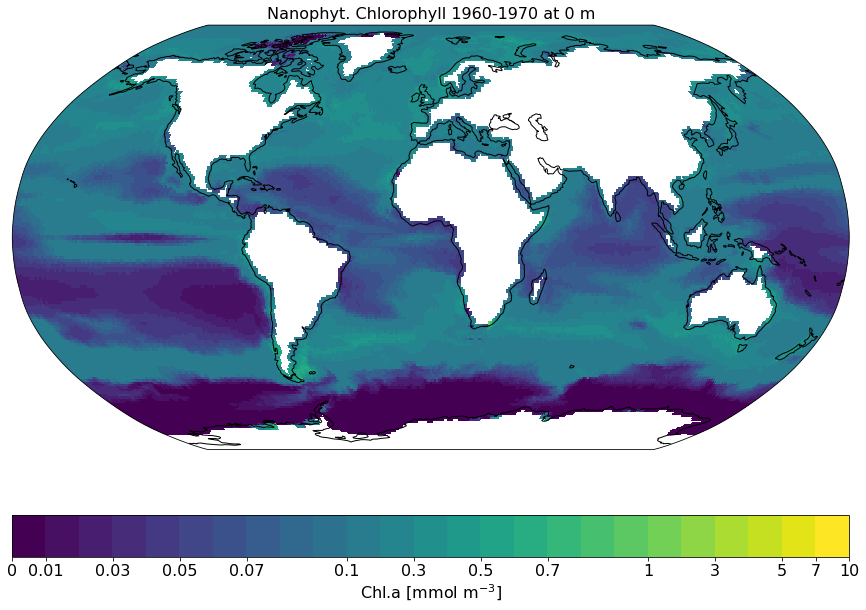

In [10]:
label='Nanophyt. Chlorophyll {0}-{1} at {2} m'.format(last_year-10,last_year,depth)
units = 'Chl.a [mmol m$^{-3}$]'


plot_Chl(resultpath,'ChlA',
         [last_year-10,last_year],
         mesh,runid,depth,mapproj,label,units)


### map of total Diatom NPP 

In [ ]:
# map of total Diatom NPP 

NCfesom = resultpath + '/NPPd.fesom.1948.nc'
#!ncdump -h $NCfesom

In [ ]:
# 12.01* data --> mmolC/m2/d to mg C/m2/d

label='Diatom NPP {0}-{1}'.format(last_year-10,last_year)
units = 'Mean NPP [mg C m$^{-2}$ d$^{-1}$]'

NPPd = pf.get_data(resultpath, "NPPd", 
                   #years, 
                   [last_year-10,last_year],
                   mesh, runid=runid, how="mean", compute=True, silent=True)

#print(np.shape(NPPd))
# NPP is already vertically integrated!

NPPd = NPPd * 12.01
fig = pf.plot(mesh, NPPd, mapproj = mapproj, units=units, titles=label, 
              levels = (0,1100,56),
              cmap='viridis')

### map of nanophytoplankton NPP

In [ ]:
# map of nanophytoplankton NPP

NCfesom = resultpath + '/NPPn.fesom.1948.nc'
#!ncdump -h $NCfesom

# 12.01* data --> mg C/m2/d

label='Nanophytoplankton NPP {0}-{1}'.format(last_year-10,last_year)
units = 'Mean NPP [mg C m$^{-2}$ d$^{-1}$]'

NPPn = pf.get_data(resultpath, "NPPn", 
                   #years, 
                   [last_year-10,last_year],
                   mesh, runid=runid, how="mean", compute=True,silent=True)

#print(np.shape(NPPn))
# NPP is already vertically integrated!

NPPn = NPPn *12.01

fig = pf.plot(mesh, NPPn, mapproj = mapproj, units=units, titles=label, 
              levels = (0,1100,56),
              cmap='viridis')

### total NPP

In [ ]:
# total NPP
label='Total Net Primary Production {0}-{1}'.format(last_year-10,last_year)
units = 'Mean total NPP [mg C m$^{-2}$ d$^{-1}$]'

NPPtot = NPPd + NPPn
fig = pf.plot(mesh, NPPtot, mapproj = mapproj, units=units, titles=label, 
              levels = (0,1100,56),
              cmap='viridis')

# Biology - MarEDAT Diatom C

In [ ]:
# Diatom carbon comparison with MarEDAT

!jupyter nbconvert --to=python DiaC_MarEDAT_python3.ipynb
from DiaC_MarEDAT_python3 import DiaC_MarEDAT_comp

maredat = DiaC_MarEDAT_comp(runid,resultpath,savepath,meshpath,ncfileMaredat,first_year,last_year,
        mapproj='pc',
        verbose = False,
        savefig=savefig)

# Biology - intracellular C, N, Si

In [ ]:
# Phytplankton carbon

NCfesom = resultpath + '/PhyC.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Phytoplankton intracell. Carbon {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'intracellular C [mmol C m$^{-3}$]'
PhyC = pf.get_data(resultpath, "PhyC", years, mesh, runid=runid, how="mean", compute=True, depth = depth)
fig = pf.plot(mesh, PhyC, mapproj = mapproj, units=units, titles=label)


In [ ]:
# Phytplankton nitrogen

NCfesom = resultpath + '/PhyN.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Phytoplankton intracell. Nitrogen {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'intracellular N [mmol C m$^{-3}$]'
PhyN = pf.get_data(resultpath, "PhyN", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, PhyN, mapproj = mapproj, units=units, titles=label)


In [ ]:
# Diatom carbon

NCfesom = resultpath + '/DiaC.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Diatom intracell. Carbon {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'intracellular C [mmol C m$^{-3}$]'
DiaC = pf.get_data(resultpath, "DiaC", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DiaC, mapproj = mapproj, units=units, titles=label)


In [ ]:
# Diatom nitrogen

NCfesom = resultpath + '/DiaN.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Diatom intracell. Nitrogen {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'intracellular N [mmol C m$^{-3}$]'
DiaN = pf.get_data(resultpath, "DiaN", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DiaN, mapproj = mapproj, units=units, titles=label)


In [ ]:
# Diatom silicate

#NCfesom = resultpath + '/DiaSi.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Diatom intracell. Silicate {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'intracellular Si [mmol m$^{-3}$]'
DiaSi = pf.get_data(resultpath, "DiaSi", years, mesh, runid=runid, how="mean", compute=True, depth=depth)

try:
    print('DiaSi \nmin {0} \nmax {1} \nmean {2} '.format(np.nanmin(DiaSi), np.nanmax(DiaSi), np.nanmean(DiaSi)))
    fig = pf.plot(mesh, DiaSi, 
                  mapproj = mapproj, 
                  units=units, titles=label)
except:
    print('*** Could not print DiaSi ***')

# extra - PCHO and TEP

In [ ]:
if False:
    label='Polysaccharides {0}-{1} at {2} m'.format(years[0],years[1],depth)
    units = 'org C [mmol m$^{-3}$]'
    PCHO = pf.get_data(resultpath, "PCHO", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
    fig = pf.plot(mesh, PCHO, mapproj = mapproj, units=units, titles=label)

In [ ]:
if False:
    label='TEP {0}-{1} at {2} m'.format(years[0],years[1],depth)
    units = 'TEP-C [mmol m$^{-3}$]'
    TEP = pf.get_data(resultpath, "TEP", years, mesh, runid=runid, how="mean", compute=True, depth=5)
    fig = pf.plot(mesh, TEP, mapproj = mapproj, units=units, titles=label)

# extra - modelled nutrients, DIC and Alk fields alone

In [ ]:
# dissolved nitrogen

NCfesom = resultpath + '/DIN.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Dissolved inorganic Nitrogen {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'DIN [mmol m$^{-3}$]'
DIN = pf.get_data(resultpath, "DIN", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DIN, mapproj = mapproj, units=units, titles=label)


In [ ]:
# dissolved Si

NCfesom = resultpath + '/DSi.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Dissolved Si {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'DSi [mmol m$^{-3}$]'
DSi = pf.get_data(resultpath, "DSi", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DSi, mapproj = mapproj, units=units, titles=label)


In [ ]:
# dissolved Fe

NCfesom = resultpath + '/DFe.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Dissolved Fe {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'DFe [mmol m$^{-3}$]'
DFe = pf.get_data(resultpath, "DFe", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DFe, mapproj = mapproj, units=units, titles=label)


In [ ]:
# DIC

NCfesom = resultpath + '/DIC.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Dissolved inorganic Carbon {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'DIC [mmol  m$^{-3}$]'
DIC = pf.get_data(resultpath, "DIC", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DIC, mapproj = mapproj, units=units, titles=label)


In [ ]:
# Alkalinity

NCfesom = resultpath + '/Alk.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Total Alkalinity {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'TA [mmol  m$^{-3}$]'
Alk = pf.get_data(resultpath, "Alk", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, Alk, mapproj = mapproj, units=units, titles=label)


# extra - gross primary production

In [ ]:
# Diatom GPP

#NCfesom = resultpath + '/GPPd.fesom.1948.nc'
#!ncdump -h $NCfesom

# 12.01* data --> mg C/m2/d

label='Mean diatom GPP {0}-{1}'.format(years[0],years[1])
units = 'GPP [mg C  m$^{-2}$ d$^{-1}$]'
GPPd = pf.get_data(resultpath, "GPPd", years, mesh, runid=runid, how="mean", compute=True, silent=True)
GPPd = GPPd * 12.01

fig = pf.plot(mesh, GPPd, mapproj = mapproj, units=units, titles=label)


In [ ]:
# Nanophytoplankton GPP

#NCfesom = resultpath + '/GPPn.fesom.1948.nc'
#!ncdump -h $NCfesom

# 12.01* data --> mg C/m2/d

label='Mean nanophytoplankton GPP {0}-{1}'.format(years[0],years[1])
units = 'GPP [mg C  m$^{-2}$ d$^{-1}$]'
GPPn = pf.get_data(resultpath, "GPPn", years, mesh, runid=runid, how="mean", compute=True, silent=True)
GPPn = GPPn * 12.01

fig = pf.plot(mesh, GPPn, mapproj = mapproj, units=units, titles=label)


In [ ]:
# total GPP

label='Mean total GPP {0}-{1}'.format(years[0],years[1])
units = 'total GPP [mg C  m$^{-2}$ d$^{-1}$]'

GPPtotal = GPPn + GPPd
fig = pf.plot(mesh, GPPtotal, mapproj = mapproj, units=units, titles=label)

# Save notebook as html

In [ ]:
%autosave 2

!jupyter nbconvert MASTER_Script_python3.ipynb --output-dir=$htmlpath --output $htmlname --to html 